<a href="https://colab.research.google.com/github/arturbeg/random_google_colabs/blob/master/gp_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic



In [0]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [0]:
# functions by https://www.kaggle.com/masayukixhirose/house-prices-advanced-regression-techniques/linear-model-roughly-modeling
def catcheck(df):
    iscat = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        if df.dtypes[c] == 'object':
            iscat[c] = 1
        else:
            iscat[c] = 0
    catdf = pd.DataFrame({'variable': df.columns, 'iscat': iscat})
    havecat = catdf[catdf.iscat == 1]
    catcolumn = havecat.variable.tolist()
    return catcolumn  

def NAcheck(df):
  missing_columns = list(df.columns[df.isnull().any()])
  print(missing_columns)
  return missing_columns

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [55]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
y_log = np.log1p(train["SalePrice"].values)
train1 = train.drop(["Id","SalePrice"], axis=1)
test1 = test.drop("Id", axis=1)

# collist = set(NAcheck(train1) + NAcheck(test1))
# train1 = train1.drop(collist, axis = 1)
# test1 = test1.drop(collist, axis = 1)

In [61]:
full_list = NAcheck(train1)
full_list.extend(NAcheck(test1))
print(full_list)
collist = set(full_list)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MSZoning', 'LotFro

In [0]:
train1 = train1.drop(collist, axis = 1)
test1 = test1.drop(collist, axis = 1)

In [65]:
print(train1.shape)

(1460, 45)


In [0]:
train1 = train1.drop(catcheck(train1), axis = 1)
test1 = test1.drop(catcheck(test1), axis = 1)

In [67]:
print(train1.columns)

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


In [0]:
X = train1.values
X_test = test1.values

In [0]:
kernel = 1.0**2 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=0.5)

Matern kernel

generalisation of the RBF
absolute exponential kernel parameterised by an additional parameter nu

The smaller nu, the less smooth the approximated function is

for nu=inf => the kernel becomes equivalent ot the RBF kernel

For nu=0.5 to the absolute exponential kernel



In [0]:
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

In [0]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]


kernel --> the covariance function of the GP
- Kernel's hyperparameters are optimised during training
- 



/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


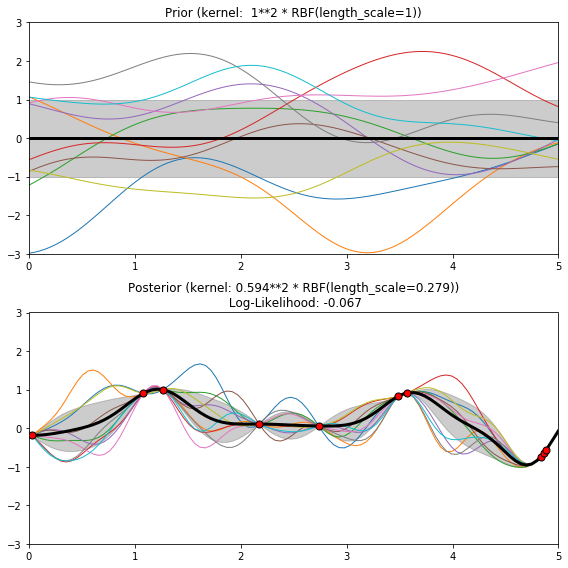

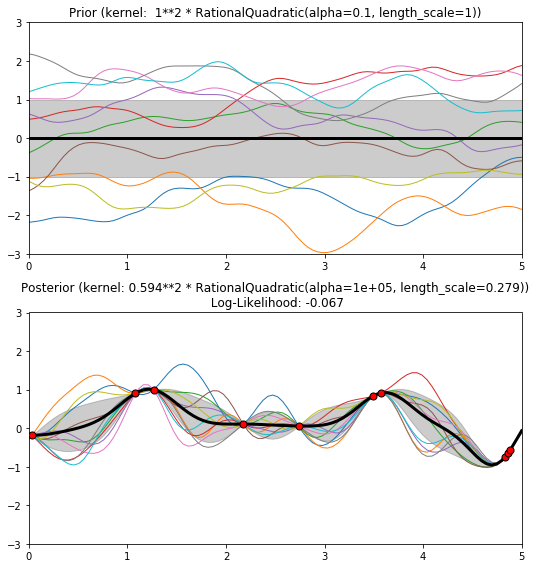

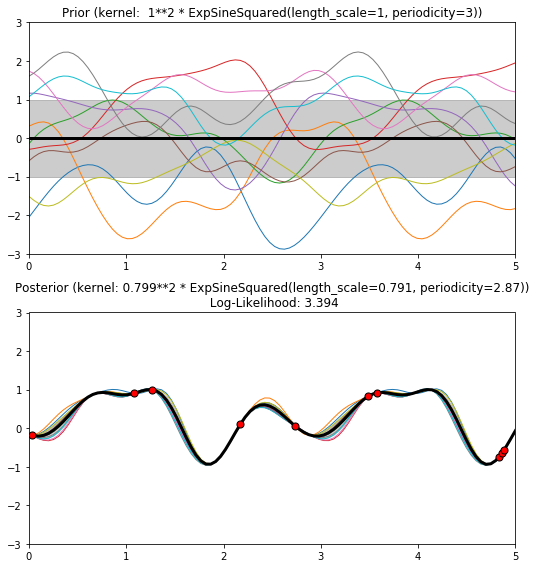

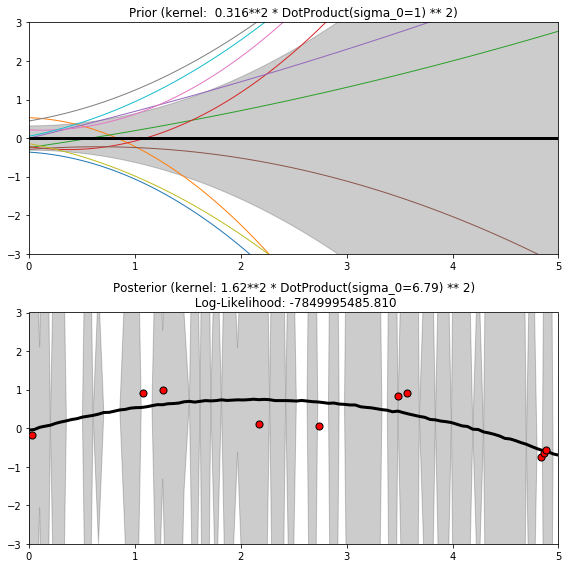

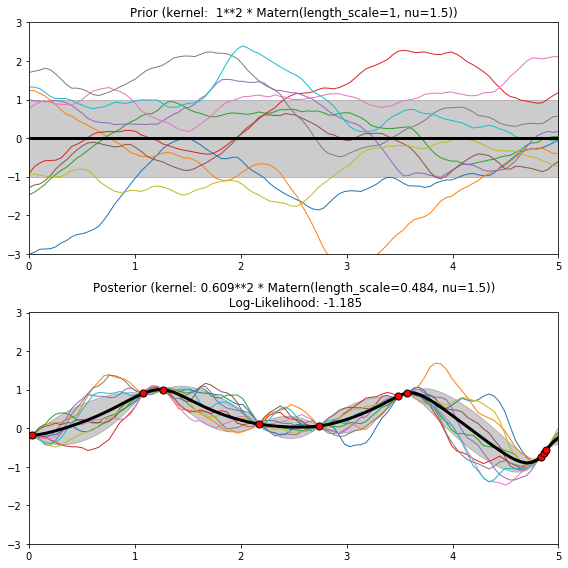

In [93]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

In [0]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=5e-9, optimizer='fmin_l_bfgs_b', 
                                n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=2016)

In [95]:
'''
- Pipeline transforms with a final estimator
- must implement fit and transform methods
- the purpose is to assemble several steps that can be
cross-validated together while setting different parameters
'''

'\n- Pipeline transforms with a final estimator\n- must implement fit and transform methods\n- the purpose is to assemble several steps that can be\ncross-validated together while setting different parameters\n'

In [0]:
clf = Pipeline([('scaler', StandardScaler()), ('gp', gp)])  

In [0]:
X = train1.values
X_test = test1.values

y_log_centered = y_log - y_log.mean()
y_pred = cross_val_predict(clf, X, y_log_centered, cv=5, n_jobs=-1)


In [0]:
y = np.expm1(y_log)

In [0]:
y_pred = np.expm1(y_pred + y_log.mean())
score = rmsle(y, y_pred)

In [103]:
print(score)

0.16639510861587517


In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

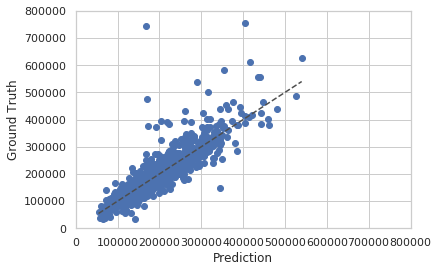

In [105]:
plt.scatter(y_pred, y)
plt.plot([min(y_pred),max(y_pred)], [min(y_pred),max(y_pred)], ls="--", c=".3")
plt.xlim([0,800000])
plt.ylim([0,800000])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.show()

In [106]:
clf.fit(X, y_log_centered)
prediction = clf.predict(X_test)
print(clf.steps[1][1].kernel_)

0.339**2 * Matern(length_scale=3.6, nu=1.5)


In [0]:
prediction = np.expm1(prediction + y_log.mean())

In [0]:
def write_to_csv(output,score):
    import datetime
    import csv
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(score) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print('Writing submission: ', sub_file)
    f = open(sub_file, 'w')
    prediction_file_object = csv.writer(f)
    prediction_file_object.writerow(["Id","SalePrice"])  # don't forget the headers

    for i in range(len(test)):
        prediction_file_object.writerow([test["Id"][test.index[i]], (output[i])])

In [109]:
write_to_csv(prediction, score)

Writing submission:  submission_0.16639510861587517_2019-11-01-18-33.csv
